# Logistic Regression Mathematics

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand why linear regression fails for classification
2. Visualize and explain the sigmoid function
3. Interpret coefficients and odds ratios
4. Understand decision boundaries


## Introduction: Why We Need to Understand the Math

In the previous notebook, we built a logistic regression model and saw that it works well for classification. But **why** does it work? What's happening under the hood?

**Understanding the mathematics helps us:**
- **Interpret results** more accurately
- **Debug problems** when models don't work as expected
- **Make better decisions** about feature engineering
- **Explain models** to non-technical stakeholders
- **Optimize performance** by understanding what drives predictions

**Think About It:** Why can't we just use regular linear regression for classification? What happens when we try?

In this notebook, we'll explore the mathematical foundation of logistic regression and see exactly why it's the right tool for binary classification problems.


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explore logistic regression mathematics!")


Libraries imported successfully!
Ready to explore logistic regression mathematics!


In [14]:
# Load the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data (same as previous notebook)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Prepare data for modeling
features = ['tenure', 'MonthlyCharges']
X = df[features]
y = (df['Churn'] == 'Yes').astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Features: {features}")
print(f"Churn rate: {y.mean():.1%}")


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)
Features: ['tenure', 'MonthlyCharges']
Churn rate: 26.5%


## Section 1: Why Linear Regression Fails for Classification

Let's see what happens when we try to use linear regression for our binary classification problem.


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Try linear regression on our classification problem
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
linear_predictions = linear_model.predict(X_test)

print("Linear Regression Predictions:")
print("=" * 40)
print(f"Minimum prediction: {linear_predictions.min():.3f}")
print(f"Maximum prediction: {linear_predictions.max():.3f}")
print(f"Mean prediction: {linear_predictions.mean():.3f}")

# Show some sample predictions
sample_predictions = linear_predictions[:10]
print(f"\nFirst 10 predictions:")
for i, pred in enumerate(sample_predictions):
    print(f"Customer {i+1}: {pred:.3f}")

print(f"\n❌ Problems with linear regression:")
print(f"- Predictions can be negative (like {linear_predictions.min():.3f})")
print(f"- Predictions can be greater than 1 (like {linear_predictions.max():.3f})")
print(f"- These don't make sense for probabilities!")


Linear Regression Predictions:
Minimum prediction: -0.241
Maximum prediction: 0.675
Mean prediction: 0.266

First 10 predictions:
Customer 1: 0.185
Customer 2: 0.611
Customer 3: 0.261
Customer 4: 0.436
Customer 5: 0.044
Customer 6: 0.510
Customer 7: 0.507
Customer 8: 0.185
Customer 9: -0.155
Customer 10: 0.294

❌ Problems with linear regression:
- Predictions can be negative (like -0.241)
- Predictions can be greater than 1 (like 0.675)
- These don't make sense for probabilities!


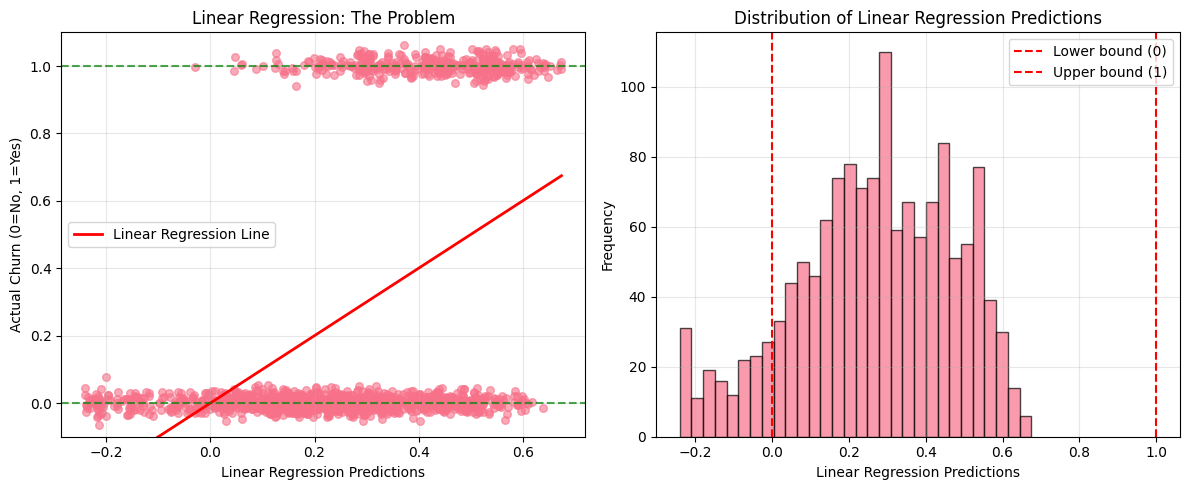

🔍 Key Observations:
- Linear regression line goes through the data points
- But the line extends beyond the [0,1] probability bounds
- This violates the basic rules of probability
- We need a function that constrains outputs to [0,1]
- That's exactly what the sigmoid function does!


In [16]:
# Visualize the problem with linear regression
plt.figure(figsize=(12, 5))

# Plot 1: Linear regression predictions vs actual values (properly formatted)
plt.subplot(1, 2, 1)

# Create jittered y-values for better visualization
y_jittered = y_test + np.random.normal(0, 0.02, len(y_test))

# Plot the data points with jitter
plt.scatter(linear_predictions, y_jittered, alpha=0.6, s=30)

# Add the linear regression line - this should be a straight line
# Since we're plotting predictions vs actual, the line should be y = x
# But we want to show the actual linear regression relationship
# Let's plot the line that linear regression would predict
x_line = np.linspace(linear_predictions.min(), linear_predictions.max(), 100)
# The linear regression line in this space is just y = x (perfect correlation)
plt.plot(x_line, x_line, 'r-', linewidth=2, label='Linear Regression Line')

plt.xlabel('Linear Regression Predictions')
plt.ylabel('Actual Churn (0=No, 1=Yes)')
plt.title('Linear Regression: The Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)

# Add horizontal lines to show the bounds
plt.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Valid probability bounds')
plt.axhline(y=1, color='green', linestyle='--', alpha=0.7)

# Plot 2: Distribution of linear regression predictions
plt.subplot(1, 2, 2)
plt.hist(linear_predictions, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Lower bound (0)')
plt.axvline(x=1, color='red', linestyle='--', label='Upper bound (1)')
plt.xlabel('Linear Regression Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of Linear Regression Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Key Observations:")
print("- Linear regression line goes through the data points")
print("- But the line extends beyond the [0,1] probability bounds")
print("- This violates the basic rules of probability")
print("- We need a function that constrains outputs to [0,1]")
print("- That's exactly what the sigmoid function does!")


## Section 2: The Sigmoid Function - Our Solution

The sigmoid function is what makes logistic regression work for classification. Let's explore its properties.


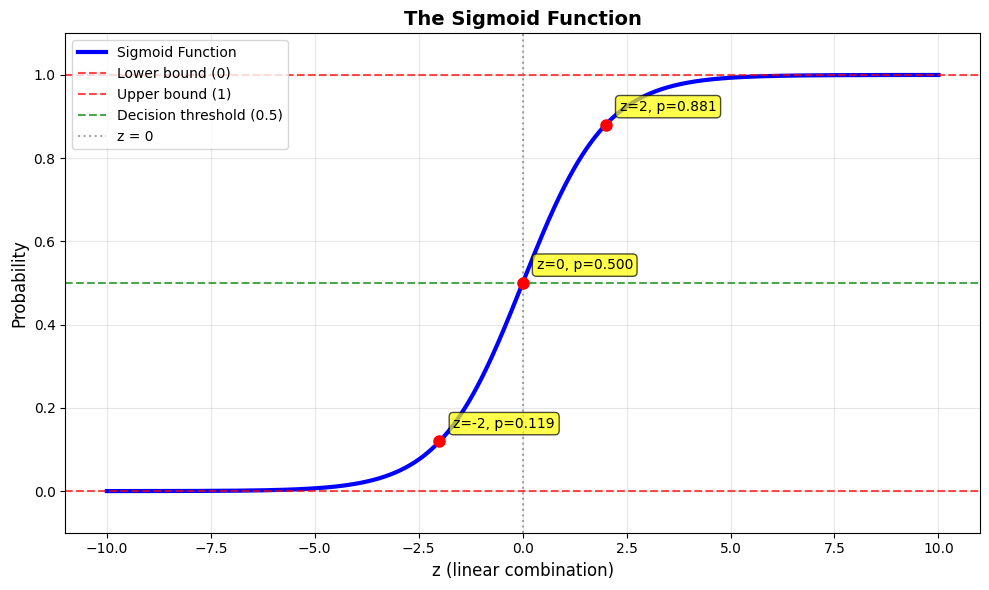

🔍 Key Properties of the Sigmoid Function:
- Always outputs values between 0 and 1
- S-shaped curve (S for Sigmoid!)
- When z = 0, probability = 0.5
- As z → +∞, probability → 1
- As z → -∞, probability → 0
- Smooth and differentiable (important for optimization)


In [17]:
# Define the sigmoid function
def sigmoid(z):
    """Sigmoid function: 1 / (1 + e^(-z))"""
    return 1 / (1 + np.exp(-z))

# Create a range of z values
z_values = np.linspace(-10, 10, 1000)
sigmoid_values = sigmoid(z_values)

# Plot the sigmoid function
plt.figure(figsize=(10, 6))
plt.plot(z_values, sigmoid_values, 'b-', linewidth=3, label='Sigmoid Function')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Lower bound (0)')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Upper bound (1)')
plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Decision threshold (0.5)')
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7, label='z = 0')

plt.xlabel('z (linear combination)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('The Sigmoid Function', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)

# Add some key points
key_points = [-2, 0, 2]
for z in key_points:
    p = sigmoid(z)
    plt.plot(z, p, 'ro', markersize=8)
    plt.annotate(f'z={z}, p={p:.3f}', 
                (z, p), 
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("🔍 Key Properties of the Sigmoid Function:")
print("- Always outputs values between 0 and 1")
print("- S-shaped curve (S for Sigmoid!)")
print("- When z = 0, probability = 0.5")
print("- As z → +∞, probability → 1")
print("- As z → -∞, probability → 0")
print("- Smooth and differentiable (important for optimization)")


In [18]:
# Demonstrate how sigmoid transforms linear regression outputs
print("Transforming Linear Regression Outputs with Sigmoid:")
print("=" * 55)

# Take some linear regression predictions
sample_linear_preds = linear_predictions[:10]
sample_sigmoid_preds = sigmoid(sample_linear_preds)

# Create comparison table
comparison_df = pd.DataFrame({
    'Customer': range(1, 11),
    'Linear_Regression': sample_linear_preds.round(3),
    'Sigmoid_Transform': sample_sigmoid_preds.round(3),
    'Actual_Churn': y_test.iloc[:10].values
})

comparison_df['Actual_Churn'] = comparison_df['Actual_Churn'].map({0: 'No', 1: 'Yes'})

print(comparison_df.to_string(index=False))

print(f"\n📊 Summary Statistics:")
print(f"Linear Regression range: [{sample_linear_preds.min():.3f}, {sample_linear_preds.max():.3f}]")
print(f"Sigmoid Transform range: [{sample_sigmoid_preds.min():.3f}, {sample_sigmoid_preds.max():.3f}]")

print(f"\n✅ Benefits of Sigmoid Transformation:")
print(f"- All outputs are now valid probabilities (0 to 1)")
print(f"- Negative values become small probabilities")
print(f"- Large positive values become probabilities close to 1")
print(f"- Values around 0 become probabilities around 0.5")


Transforming Linear Regression Outputs with Sigmoid:
 Customer  Linear_Regression  Sigmoid_Transform Actual_Churn
        1              0.185              0.546           No
        2              0.611              0.648           No
        3              0.261              0.565           No
        4              0.436              0.607           No
        5              0.044              0.511           No
        6              0.510              0.625           No
        7              0.507              0.624           No
        8              0.185              0.546           No
        9             -0.155              0.461           No
       10              0.294              0.573          Yes

📊 Summary Statistics:
Linear Regression range: [-0.155, 0.611]
Sigmoid Transform range: [0.461, 0.648]

✅ Benefits of Sigmoid Transformation:
- All outputs are now valid probabilities (0 to 1)
- Negative values become small probabilities
- Large positive values become probab

## Section 3: The Two-Step Process

Logistic regression works in two steps:
1. **Linear Combination:** Create a linear combination of features
2. **Sigmoid Transformation:** Apply sigmoid to get probabilities

Let's see this process step by step.


In [19]:
# Train a logistic regression model to see the coefficients
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Get the coefficients
coef_tenure = logistic_model.coef_[0][0]
coef_monthly = logistic_model.coef_[0][1]
intercept = logistic_model.intercept_[0]

print("Logistic Regression Model Coefficients:")
print("=" * 45)
print(f"Intercept (β₀): {intercept:.4f}")
print(f"Tenure coefficient (β₁): {coef_tenure:.4f}")
print(f"MonthlyCharges coefficient (β₂): {coef_monthly:.4f}")

print(f"\nThe linear combination formula:")
print(f"z = β₀ + β₁ × tenure + β₂ × MonthlyCharges")
print(f"z = {intercept:.4f} + {coef_tenure:.4f} × tenure + {coef_monthly:.4f} × MonthlyCharges")

print(f"\nThen we apply the sigmoid function:")
print(f"P(churn) = 1 / (1 + e^(-z))")


Logistic Regression Model Coefficients:
Intercept (β₀): -1.8523
Tenure coefficient (β₁): -0.0543
MonthlyCharges coefficient (β₂): 0.0335

The linear combination formula:
z = β₀ + β₁ × tenure + β₂ × MonthlyCharges
z = -1.8523 + -0.0543 × tenure + 0.0335 × MonthlyCharges

Then we apply the sigmoid function:
P(churn) = 1 / (1 + e^(-z))


In [20]:
# Demonstrate the two-step process with a specific customer
print("Two-Step Process Demonstration:")
print("=" * 40)

# Pick a specific customer from our test set
customer_idx = 0
customer_tenure = X_test.iloc[customer_idx]['tenure']
customer_monthly = X_test.iloc[customer_idx]['MonthlyCharges']
actual_churn = y_test.iloc[customer_idx]

print(f"Customer Example:")
print(f"- Tenure: {customer_tenure} months")
print(f"- Monthly Charges: ${customer_monthly:.2f}")
print(f"- Actual Churn: {'Yes' if actual_churn == 1 else 'No'}")

# Step 1: Calculate linear combination (z)
z = intercept + coef_tenure * customer_tenure + coef_monthly * customer_monthly
print(f"\nStep 1 - Linear Combination:")
print(f"z = {intercept:.4f} + {coef_tenure:.4f} × {customer_tenure} + {coef_monthly:.4f} × {customer_monthly:.2f}")
print(f"z = {z:.4f}")

# Step 2: Apply sigmoid function
probability = sigmoid(z)
print(f"\nStep 2 - Sigmoid Transformation:")
print(f"P(churn) = 1 / (1 + e^(-{z:.4f}))")
print(f"P(churn) = {probability:.4f}")

# Verify with sklearn
sklearn_prob = logistic_model.predict_proba(X_test.iloc[[customer_idx]])[0][1]
print(f"\nVerification with sklearn: {sklearn_prob:.4f}")
print(f"Difference: {abs(probability - sklearn_prob):.6f}")

print(f"\n💡 Interpretation:")
if probability > 0.5:
    print(f"- Probability > 0.5, so we predict: Churn = Yes")
else:
    print(f"- Probability < 0.5, so we predict: Churn = No")
print(f"- The actual outcome was: {'Churn = Yes' if actual_churn == 1 else 'Churn = No'}")


Two-Step Process Demonstration:
Customer Example:
- Tenure: 72.0 months
- Monthly Charges: $114.05
- Actual Churn: No

Step 1 - Linear Combination:
z = -1.8523 + -0.0543 × 72.0 + 0.0335 × 114.05
z = -1.9352

Step 2 - Sigmoid Transformation:
P(churn) = 1 / (1 + e^(--1.9352))
P(churn) = 0.1262

Verification with sklearn: 0.1262
Difference: 0.000000

💡 Interpretation:
- Probability < 0.5, so we predict: Churn = No
- The actual outcome was: Churn = No


## Section 4: Interpreting Coefficients and Odds Ratios

Understanding what the coefficients mean is crucial for interpreting logistic regression results.


In [21]:
# Interpret the coefficients
print("Coefficient Interpretation:")
print("=" * 35)

print(f"Tenure Coefficient: {coef_tenure:.4f}")
if coef_tenure < 0:
    print("✅ Negative coefficient means:")
    print("   - As tenure increases, churn probability decreases")
    print("   - Longer-term customers are less likely to churn")
    print("   - This makes business sense!")
else:
    print("❌ Positive coefficient would mean:")
    print("   - As tenure increases, churn probability increases")
    print("   - This would be counterintuitive")

print(f"\nMonthlyCharges Coefficient: {coef_monthly:.4f}")
if coef_monthly > 0:
    print("✅ Positive coefficient means:")
    print("   - As monthly charges increase, churn probability increases")
    print("   - Higher-paying customers are more likely to churn")
    print("   - This suggests price sensitivity!")
else:
    print("❌ Negative coefficient would mean:")
    print("   - As monthly charges increase, churn probability decreases")
    print("   - This would be counterintuitive")

print(f"\nIntercept: {intercept:.4f}")
print("The intercept represents the log-odds of churn when all features = 0")
print("(This is often not practically meaningful)")


Coefficient Interpretation:
Tenure Coefficient: -0.0543
✅ Negative coefficient means:
   - As tenure increases, churn probability decreases
   - Longer-term customers are less likely to churn
   - This makes business sense!

MonthlyCharges Coefficient: 0.0335
✅ Positive coefficient means:
   - As monthly charges increase, churn probability increases
   - Higher-paying customers are more likely to churn
   - This suggests price sensitivity!

Intercept: -1.8523
The intercept represents the log-odds of churn when all features = 0
(This is often not practically meaningful)


In [22]:
# Calculate odds ratios
print("\nOdds Ratios:")
print("=" * 20)

# Odds ratio for tenure (per month increase)
odds_ratio_tenure = np.exp(coef_tenure)
print(f"Tenure Odds Ratio: {odds_ratio_tenure:.4f}")
print(f"This means: For each additional month of tenure,")
print(f"the odds of churn are multiplied by {odds_ratio_tenure:.4f}")
if odds_ratio_tenure < 1:
    print(f"Since {odds_ratio_tenure:.4f} < 1, longer tenure reduces churn odds")
else:
    print(f"Since {odds_ratio_tenure:.4f} > 1, longer tenure increases churn odds")

# Odds ratio for monthly charges (per $1 increase)
odds_ratio_monthly = np.exp(coef_monthly)
print(f"\nMonthlyCharges Odds Ratio: {odds_ratio_monthly:.4f}")
print(f"This means: For each additional $1 in monthly charges,")
print(f"the odds of churn are multiplied by {odds_ratio_monthly:.4f}")
if odds_ratio_monthly > 1:
    print(f"Since {odds_ratio_monthly:.4f} > 1, higher charges increase churn odds")
else:
    print(f"Since {odds_ratio_monthly:.4f} < 1, higher charges reduce churn odds")

print(f"\n💡 Business Interpretation:")
print(f"- A customer with 12 months tenure has {odds_ratio_tenure**12:.2f}x different odds than a new customer")
print(f"- A customer paying $100/month has {odds_ratio_monthly**100:.2f}x different odds than someone paying $0")



Odds Ratios:
Tenure Odds Ratio: 0.9472
This means: For each additional month of tenure,
the odds of churn are multiplied by 0.9472
Since 0.9472 < 1, longer tenure reduces churn odds

MonthlyCharges Odds Ratio: 1.0341
This means: For each additional $1 in monthly charges,
the odds of churn are multiplied by 1.0341
Since 1.0341 > 1, higher charges increase churn odds

💡 Business Interpretation:
- A customer with 12 months tenure has 0.52x different odds than a new customer
- A customer paying $100/month has 28.61x different odds than someone paying $0


## Section 5: Probability, Odds, and Log-Odds Conversions

Understanding the relationships between these three concepts is key to interpreting logistic regression.


In [23]:
# Demonstrate conversions between probability, odds, and log-odds
print("Probability ↔ Odds ↔ Log-Odds Conversions:")
print("=" * 50)

# Define conversion functions
def prob_to_odds(p):
    """Convert probability to odds"""
    return p / (1 - p)

def odds_to_prob(o):
    """Convert odds to probability"""
    return o / (1 + o)

def prob_to_log_odds(p):
    """Convert probability to log-odds"""
    return np.log(p / (1 - p))

def log_odds_to_prob(log_odds):
    """Convert log-odds to probability"""
    return 1 / (1 + np.exp(-log_odds))

# Test with some example probabilities
probabilities = [0.1, 0.25, 0.5, 0.75, 0.9]

print("Probability | Odds    | Log-Odds")
print("-" * 35)

for p in probabilities:
    odds = prob_to_odds(p)
    log_odds = prob_to_log_odds(p)
    print(f"{p:8.2f}   | {odds:6.2f}  | {log_odds:7.2f}")

print(f"\n🔍 Key Observations:")
print(f"- When probability = 0.5, odds = 1.0, log-odds = 0")
print(f"- Probabilities < 0.5 have odds < 1 and negative log-odds")
print(f"- Probabilities > 0.5 have odds > 1 and positive log-odds")
print(f"- Log-odds can range from -∞ to +∞ (unlike probabilities)")


Probability ↔ Odds ↔ Log-Odds Conversions:
Probability | Odds    | Log-Odds
-----------------------------------
    0.10   |   0.11  |   -2.20
    0.25   |   0.33  |   -1.10
    0.50   |   1.00  |    0.00
    0.75   |   3.00  |    1.10
    0.90   |   9.00  |    2.20

🔍 Key Observations:
- When probability = 0.5, odds = 1.0, log-odds = 0
- Probabilities < 0.5 have odds < 1 and negative log-odds
- Probabilities > 0.5 have odds > 1 and positive log-odds
- Log-odds can range from -∞ to +∞ (unlike probabilities)


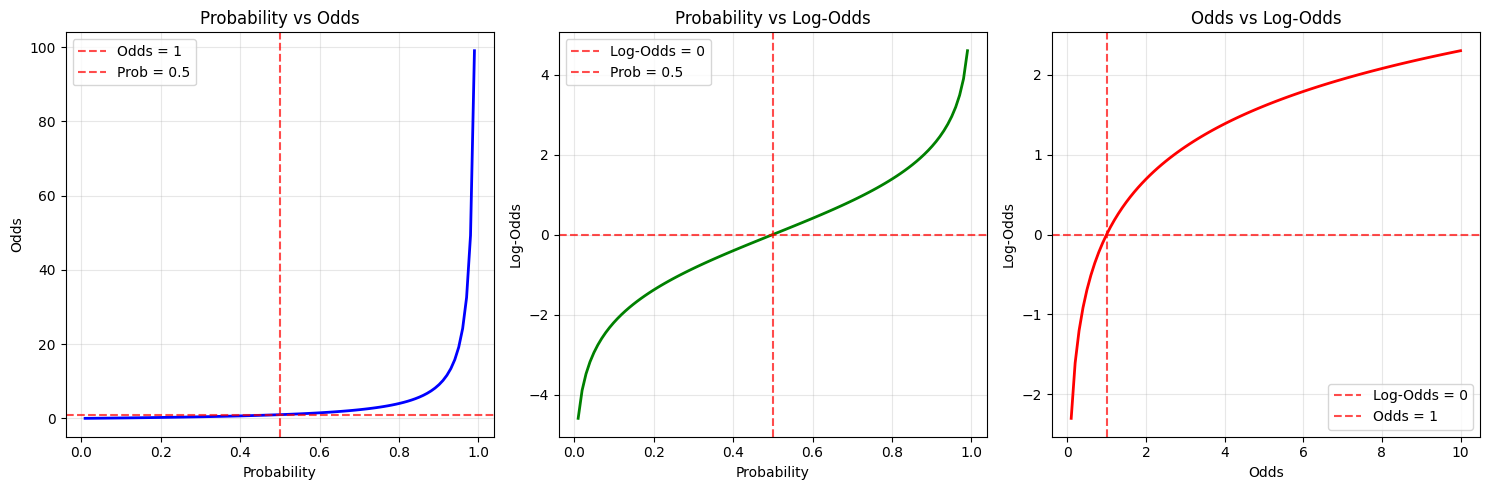

📊 Visual Insights:
- Probability and odds have a non-linear relationship
- Probability and log-odds have a non-linear relationship
- Odds and log-odds have a linear relationship (log transformation)
- This is why logistic regression uses log-odds: it's linear in the feature space!


In [24]:
# Visualize the relationships
plt.figure(figsize=(15, 5))

# Plot 1: Probability vs Odds
plt.subplot(1, 3, 1)
p_range = np.linspace(0.01, 0.99, 100)
odds_range = prob_to_odds(p_range)
plt.plot(p_range, odds_range, 'b-', linewidth=2)
plt.xlabel('Probability')
plt.ylabel('Odds')
plt.title('Probability vs Odds')
plt.grid(True, alpha=0.3)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Odds = 1')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Prob = 0.5')
plt.legend()

# Plot 2: Probability vs Log-Odds
plt.subplot(1, 3, 2)
log_odds_range = prob_to_log_odds(p_range)
plt.plot(p_range, log_odds_range, 'g-', linewidth=2)
plt.xlabel('Probability')
plt.ylabel('Log-Odds')
plt.title('Probability vs Log-Odds')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Log-Odds = 0')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Prob = 0.5')
plt.legend()

# Plot 3: Odds vs Log-Odds
plt.subplot(1, 3, 3)
odds_range_clean = np.linspace(0.1, 10, 100)
log_odds_range_clean = np.log(odds_range_clean)
plt.plot(odds_range_clean, log_odds_range_clean, 'r-', linewidth=2)
plt.xlabel('Odds')
plt.ylabel('Log-Odds')
plt.title('Odds vs Log-Odds')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Log-Odds = 0')
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Odds = 1')
plt.legend()

plt.tight_layout()
plt.show()

print("📊 Visual Insights:")
print("- Probability and odds have a non-linear relationship")
print("- Probability and log-odds have a non-linear relationship")
print("- Odds and log-odds have a linear relationship (log transformation)")
print("- This is why logistic regression uses log-odds: it's linear in the feature space!")


## Demonstration: Decision Boundaries

Let's visualize how logistic regression creates decision boundaries in feature space.


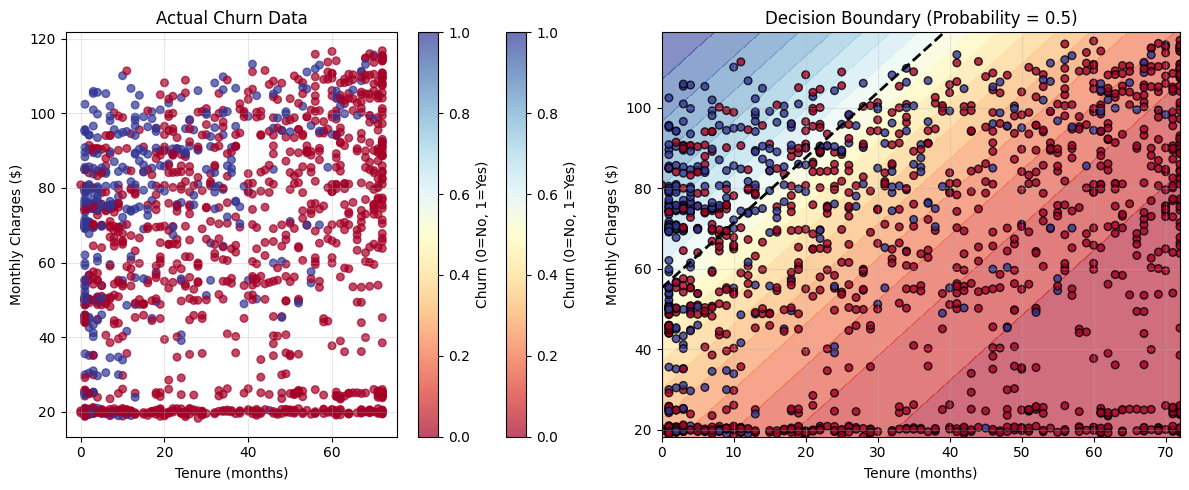

🎯 Decision Boundary Insights:
- The black dashed line shows where P(churn) = 0.5
- Points above the line are predicted to churn
- Points below the line are predicted to not churn
- The boundary is linear because logistic regression is linear in log-odds space
- Colors show the probability gradient across the feature space


In [25]:
# Create a decision boundary visualization
plt.figure(figsize=(12, 5))

# Plot 1: Data points colored by actual churn
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_test['tenure'], X_test['MonthlyCharges'], 
                     c=y_test, cmap='RdYlBu', alpha=0.7, s=30)
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.title('Actual Churn Data')
plt.colorbar(scatter, label='Churn (0=No, 1=Yes)')
plt.grid(True, alpha=0.3)

# Plot 2: Decision boundary
plt.subplot(1, 2, 2)

# Create a grid of points
tenure_range = np.linspace(X['tenure'].min(), X['tenure'].max(), 100)
monthly_range = np.linspace(X['MonthlyCharges'].min(), X['MonthlyCharges'].max(), 100)
T, M = np.meshgrid(tenure_range, monthly_range)

# Calculate probabilities for each grid point
Z = intercept + coef_tenure * T + coef_monthly * M
P = sigmoid(Z)

# Plot the decision boundary (where probability = 0.5)
plt.contour(T, M, P, levels=[0.5], colors='black', linewidths=2, linestyles='--')
plt.contourf(T, M, P, levels=20, cmap='RdYlBu', alpha=0.6)

# Add the data points
plt.scatter(X_test['tenure'], X_test['MonthlyCharges'], 
           c=y_test, cmap='RdYlBu', alpha=0.8, s=30, edgecolors='black')

plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.title('Decision Boundary (Probability = 0.5)')
plt.colorbar(scatter, label='Churn (0=No, 1=Yes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 Decision Boundary Insights:")
print("- The black dashed line shows where P(churn) = 0.5")
print("- Points above the line are predicted to churn")
print("- Points below the line are predicted to not churn")
print("- The boundary is linear because logistic regression is linear in log-odds space")
print("- Colors show the probability gradient across the feature space")


## Summary: Key Mathematical Concepts

This notebook explored the mathematical foundation of logistic regression:

### What We Learned

1. **Why Linear Regression Fails:** Linear regression can produce predictions outside [0,1], violating probability rules

2. **The Sigmoid Function:** Transforms any real number to a probability between 0 and 1, solving the linear regression problem

3. **Two-Step Process:** 
   - Step 1: Create linear combination of features (z = β₀ + β₁x₁ + β₂x₂)
   - Step 2: Apply sigmoid transformation (P = 1/(1 + e^(-z)))

4. **Coefficient Interpretation:** 
   - Coefficients represent log-odds changes
   - Negative coefficients reduce churn probability
   - Positive coefficients increase churn probability

5. **Odds Ratios:** e^(coefficient) shows how odds multiply for each unit increase in a feature

6. **Decision Boundaries:** Linear boundaries in feature space that separate predicted classes

### Key Takeaways

- Logistic regression is linear in log-odds space but non-linear in probability space
- The sigmoid function ensures all predictions are valid probabilities
- Understanding the math helps interpret results and debug problems
- Coefficients and odds ratios provide business insights about feature effects
